# Predict Future Sales

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import product

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.cluster import KMeans

from scipy.stats import loguniform, uniform
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/competitive-data-science-predict-future-sales/'
raw_df = pd.read_csv(data_dir + 'sales_train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')
items_df = pd.read_csv(data_dir + 'items.csv')
item_cat_df = pd.read_csv(data_dir + 'item_categories.csv')
shops_df = pd.read_csv(data_dir + 'shops.csv')

In [3]:
raw_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [5]:
items_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [6]:
item_cat_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [7]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
raw_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## Data Cleaning

### Remove outliers

<Axes: xlabel='item_price'>

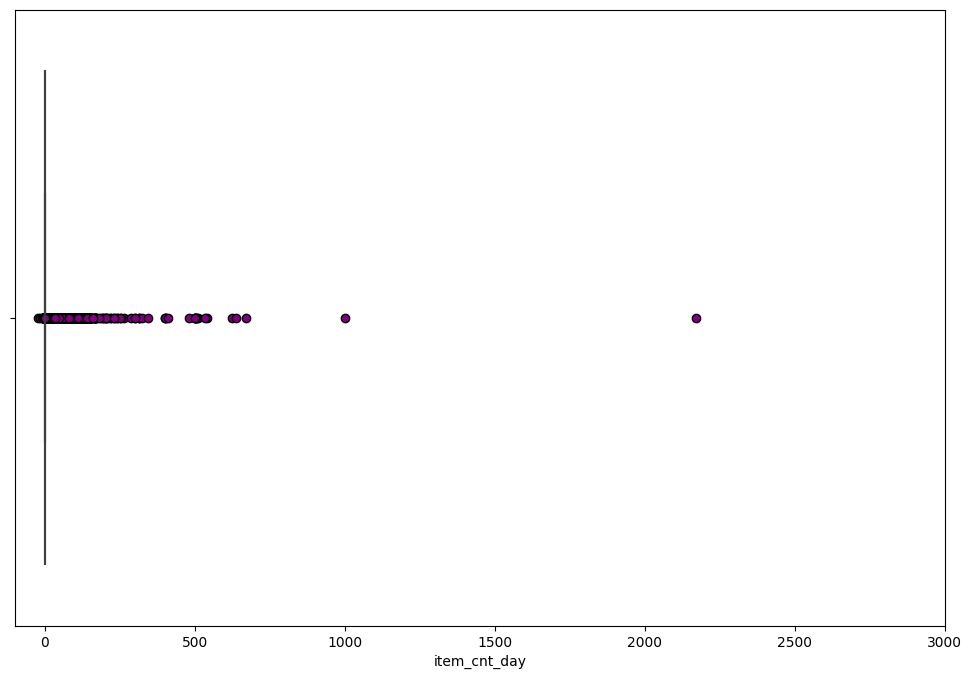

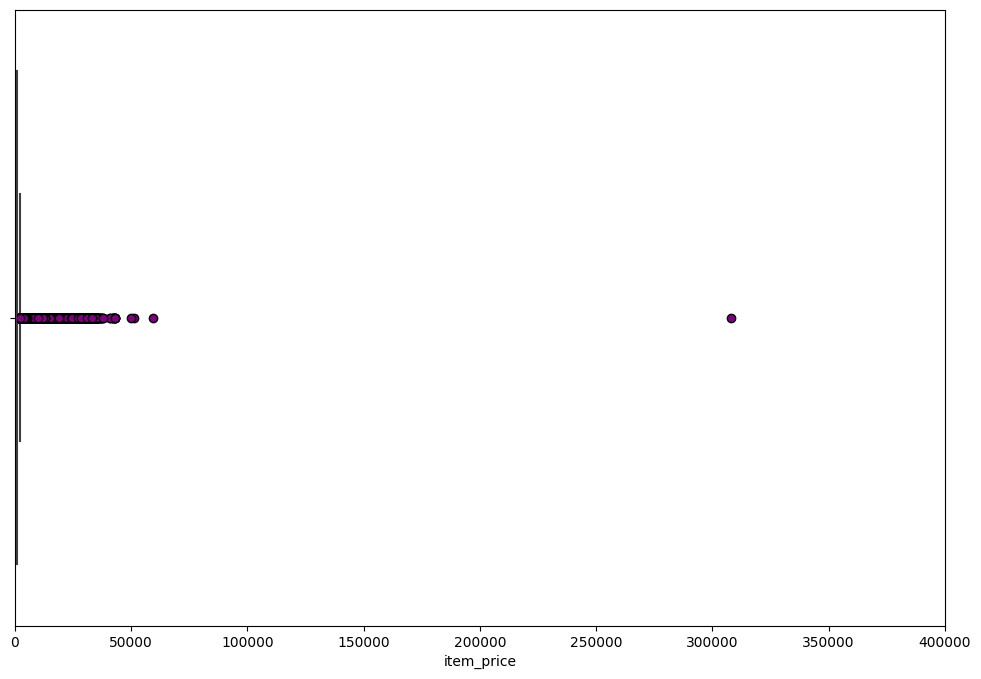

In [9]:
plt.figure(figsize=(12,8))
plt.xlim(-100,3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=raw_df['item_cnt_day'], flierprops=flierprops)

plt.figure(figsize=(12,8))
plt.xlim(-50,4e5)
sns.boxplot(x=raw_df['item_price'], flierprops=flierprops)

So we remove row has `item_price>=300000` or `item_cnt_day>=1000`

In [10]:
raw_df = raw_df[(raw_df['item_price']<300000)&(raw_df['item_cnt_day']<1000)]

And we remove the negative values of `item_price` and make zeros with negative values of `item_cnt_day`.

In [11]:
raw_df = raw_df[raw_df['item_price']>0].reset_index(drop=True)
raw_df['item_cnt_day'] = raw_df['item_cnt_day'].apply(lambda x: 0 if x<1 else x)

### Cleaning Shop Data

In [12]:
shops_df

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Several of shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [13]:
def drop_duplicate_shop(x):
    if x==0:
        return 57 # Якутск Орджоникидзе, 56 (0 and 57)
    if x==1:
        return 58 # Якутск ТЦ "Центральный"	(1 and 58)
    if x==10:
        return 11 # Жуковский ул. Чкалова 39м² (10 and 11)
    return x

for df in [raw_df, test_df]:
    df['shop_id'] = df['shop_id'].apply(lambda x: drop_duplicate_shop(x))

The first part and second part of `shop_name`, which are separated by `' '`, look like city and category of shops. We can split `shop_name` like this.

In [14]:
# First replace a shop name to more reasonable form.
shops_df['shop_name'] = shops_df['shop_name'].apply(lambda x: 'СергиевПосад ТЦ "7Я"' 
                                                    if x=='Сергиев Посад ТЦ "7Я"' else x)

In [15]:
shops_df['shop_city'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[0])
shops_df['shop_category'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[1])
# And simple a city
shops_df['shop_city'] = shops_df['shop_city'].apply(lambda x: 'Якутск' if x=='!Якутск' else x)

We keep category where appear at least 5 times.

In [16]:
shop_cats = shops_df['shop_category'].value_counts()
shop_cats = shop_cats[shop_cats>=5]
shop_cats_idx = shop_cats.index.tolist()
shops_df['shop_category'] = shops_df['shop_category'].apply(lambda x: x if x in shop_cats_idx else 'rem')

In [17]:
encoder = OrdinalEncoder()
shops_df[['shop_city','shop_category']] = encoder.fit_transform(shops_df[['shop_city','shop_category']])

In [18]:
shops_df = shops_df[['shop_id','shop_city','shop_category']]

### Cleaning Item Category Data

In [19]:
item_cat_df.head(50)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [20]:
item_cat_df['item_category_type'] = item_cat_df['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_cat_df['item_category_type'] = item_cat_df['item_category_type'].apply(lambda x: 'Игры' 
                                                                            if (x=='Игровые') or (x=='Аксессуары') 
                                                                            else x)

In [21]:
item_cat_types = item_cat_df['item_category_type'].value_counts()
item_cat_types = item_cat_types[item_cat_types>=5]
item_cat_types_idx = item_cat_types.index.tolist()
item_cat_df['item_category_type'] = item_cat_df['item_category_type'].apply(lambda x: x if x in item_cat_types_idx else 'rem')

In [22]:
item_cat_df['split_sub'] = item_cat_df['item_category_name'].apply(lambda x: str(x).split('-'))
item_cat_df['item_category_sub_type'] = item_cat_df['split_sub'].apply(lambda x: x[1].strip() if len(x)>1 else x[0].strip())

In [23]:
encoder = OrdinalEncoder()
item_cat_df[['item_category_type','item_category_sub_type']] = encoder.fit_transform(item_cat_df[['item_category_type','item_category_sub_type']])

In [24]:
item_cat_df = item_cat_df[['item_category_id','item_category_type','item_category_sub_type']]

### Cleaning Item Data

In [25]:
items_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [26]:
def correct_item(x):
    x = x.lower() # LowerCase
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub(r'[^A-Za-z0-9А-Яа-я]+',' ',x) # remove special char
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [27]:
'a'.split('[')

['a']

In [28]:
# split item names by first bracket
items_df['item_name1'] = items_df['item_name'].apply(lambda x: re.split(r'[\[\(]',x,1)[0])
items_df['item_name2'] = items_df['item_name'].apply(lambda x: str(x).split('[',1)[1] if str(x).find('[')>=0 else '0')
items_df['item_name3'] = items_df['item_name'].apply(lambda x: str(x).split('(',1)[1] if str(x).find('(')>=0 else '0')

In [29]:
items_df

,item_name,item_id,item_category_id,item_name1,item_name2,item_name3
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,ПЛАСТ.) D
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,!ABBYY FineReader 12 Professional Edition Full,"PC, Цифровая версия]",0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***В ЛУЧАХ СЛАВЫ,0,UNV) D
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***ГОЛУБАЯ ВОЛНА,0,Univ) D
4,***КОРОБКА (СТЕКЛО) D,4,40,***КОРОБКА,0,СТЕКЛО) D
...,...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,Ядерный титбит 2,"PC, Цифровая версия]",0
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,Язык запросов 1С:Предприятия,Цифровая версия],0
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Язык запросов 1С:Предприятия 8,0,+CD). Хрусталева Е.Ю.
22168,Яйцо для Little Inu,22168,62,Яйцо для Little Inu,0,0


In [30]:
for i in [1,2,3]:
    col = f'item_name{i}'
    items_df[col] = items_df[col].apply(lambda x: correct_item(str(x)))

In [31]:
items_df['item_name2'] = items_df['item_name2'].apply(lambda x: '0' if x=='' else x)

In [32]:
items_df['item_type'] = items_df['item_name2'].apply(lambda x: x[0:8]
                                                     if x.split(' ')[0]=='xbox'
                                                     else x.split(' ')[0])
items_df['item_type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', 'p', 'mac', 'psp',
       'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360', 'русская', 'рс',
       'android', 'англ', 'ps2', 'только', 'цифров', '6jv', 'j72', 'hm3',
       's3v', '6dv', '6l6', '5f4', 's4v', 'kg4', '5c5', '5c7', 'kf7',
       'kf6'], dtype=object)

In [33]:
def clean_item_type(x):
    if x=='xbox 360' or x=='x360' or x=='xbox360':
        return 'x360'
    if x=='pc' or x=='pс' or x=='рс':
        return 'pc'
    if x=='ps3' or x=='рs3':
        return 'ps3'
    return x
items_df['item_type'] = items_df['item_type'].apply(lambda x: clean_item_type(x))

In [34]:
item_types = items_df['item_type'].value_counts()
item_types = item_types[item_types>=20]
item_types_idx = item_types.index.tolist()
items_df['item_type'] = items_df['item_type'].apply(lambda x: x if x in item_types_idx else 'rem')

In [35]:
encoder = OrdinalEncoder()
items_df[['item_name2','item_name3','item_type']] = encoder.fit_transform(items_df[['item_name2','item_name3','item_type']])

In [36]:
items_df

,item_name,item_id,item_category_id,item_name1,item_name2,item_name3,item_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения,0.0,1083.0,0.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full,59.0,1.0,2.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы,0.0,795.0,0.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна,0.0,794.0,0.0
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка,0.0,1285.0,0.0
...,...,...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,ядерный титбит 2,59.0,1.0,2.0
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,язык запросов 1с предприятия,139.0,1.0,10.0
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,язык запросов 1с предприятия 8,0.0,461.0,0.0
22168,Яйцо для Little Inu,22168,62,яйцо для little inu,0.0,1.0,0.0


In [37]:
items_df = items_df[['item_id','item_category_id','item_name2','item_name3','item_type']]

## Feature Engineering and Preprocessing

Create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [38]:
raw_df['revenue'] = raw_df['item_cnt_day'] * raw_df['item_price']

In [39]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = raw_df[raw_df['date_block_num']==i]
    matrix.append(np.array(list(product([i],sales['shop_id'].unique(),sales['item_id'].unique())), dtype=np.int16))

matrix_df = pd.DataFrame(data=np.vstack(matrix), columns=cols)
matrix_df["date_block_num"] = matrix_df["date_block_num"].astype('int8')
matrix_df["shop_id"] = matrix_df["shop_id"].astype('int8')
matrix_df["item_id"] = matrix_df["item_id"].astype('int16')
matrix_df.sort_values(cols, inplace=True)

In [40]:
matrix_df = matrix_df.reset_index(drop=True)

In [41]:
group = raw_df.groupby(cols)['item_cnt_day'].aggregate(['sum'])
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [42]:
matrix_df = pd.merge(matrix_df, group, on=cols, how='left')
matrix_df.fillna({'item_cnt_month':0},inplace=True)
matrix_df['item_cnt_month'] = matrix_df['item_cnt_month'].astype('float16')

In [43]:
matrix_df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


Create test set with `date_block_num=34`

In [44]:
test_df['date_block_num'] = 34
test_df['date_block_num'] = test_df['date_block_num'].astype('int8')
test_df['shop_id'] = test_df['shop_id'].astype('int8')
test_df['item_id'] = test_df['item_id'].astype('int16')
test_df.drop(columns='ID',inplace=True)

In [45]:
concat_df = pd.concat([matrix_df,test_df]).copy()
concat_df = concat_df.reset_index(drop=True)
concat_df.fillna({'item_cnt_month':0},inplace=True)

In [46]:
concat_df = pd.merge(concat_df, items_df, on='item_id', how='left')
concat_df = pd.merge(concat_df, item_cat_df, on='item_category_id', how='left')
concat_df = pd.merge(concat_df, shops_df, on='shop_id', how='left')
concat_df.dtypes

date_block_num               int8
shop_id                      int8
item_id                     int16
item_cnt_month            float16
item_category_id            int64
item_name2                float64
item_name3                float64
item_type                 float64
item_category_type        float64
item_category_sub_type    float64
shop_city                 float64
shop_category             float64
dtype: object

In [47]:
for col in ['item_category_id','item_type','item_category_type',
            'item_category_sub_type','shop_city','shop_category']:
    concat_df[col] = concat_df[col].astype('int8')
concat_df['item_name2'] = concat_df['item_name2'].astype('int16')
concat_df['item_name3'] = concat_df['item_name3'].astype('int16')

Now, we add lag feature

In [48]:
def create_lag_feature(df, lags, features):
    for feature in features:
        print(feature)
        for lag in lags:
            shifted = df[['date_block_num','shop_id','item_id',feature]].copy()
            shifted.columns = ['date_block_num','shop_id','item_id',f'{feature}_lag_{lag}']
            shifted['date_block_num'] = shifted['date_block_num'] + lag
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [49]:
lag_for_ml = [i+1 for i in range(3)]
lag_for_lstm = [i+1 for i in range(6)]

In [50]:
%%time
concat_df = create_lag_feature(concat_df, lags=lag_for_lstm, features=['item_cnt_month'])

item_cnt_month
CPU times: user 30 s, sys: 7.48 s, total: 37.5 s
Wall time: 37.5 s


Add the previous month's average item_cnt.

In [51]:
%%time
group = concat_df.groupby('date_block_num')['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on='date_block_num', how='left')
concat_df['date_block_item_cnt_mean'] = concat_df['date_block_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_item_cnt_mean'])
concat_df.drop(columns='date_block_item_cnt_mean', inplace=True)

date_block_item_cnt_mean
CPU times: user 31.2 s, sys: 8.35 s, total: 39.6 s
Wall time: 39.6 s


Add lag values of item_cnt_month for month / item_id.

In [52]:
%%time
group = concat_df.groupby(['date_block_num','item_id'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_item_id_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','item_id'], how='left')
concat_df['date_block_item_id_item_cnt_mean'] = concat_df['date_block_item_id_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_item_id_item_cnt_mean'])
concat_df.drop(columns='date_block_item_id_item_cnt_mean', inplace=True)

date_block_item_id_item_cnt_mean
CPU times: user 32.5 s, sys: 9.25 s, total: 41.8 s
Wall time: 41.7 s


Add lag values of item_cnt_month for month / shop_id.

In [53]:
%%time
group = concat_df.groupby(['date_block_num','shop_id'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_shop_id_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_id'], how='left')
concat_df['date_block_shop_id_item_cnt_mean'] = concat_df['date_block_shop_id_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_shop_id_item_cnt_mean'])
concat_df.drop(columns='date_block_shop_id_item_cnt_mean', inplace=True)

date_block_shop_id_item_cnt_mean
CPU times: user 32.8 s, sys: 9.99 s, total: 42.8 s
Wall time: 42.8 s


Add lag values for item_cnt_month for month/shop/item.

In [54]:
%%time
group = concat_df.groupby(['date_block_num','shop_id','item_id'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_shop_id_item_id_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_id','item_id'], how='left')
concat_df['date_block_shop_id_item_id_item_cnt_mean'] = concat_df['date_block_shop_id_item_id_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_shop_id_item_id_item_cnt_mean'])
concat_df.drop(columns='date_block_shop_id_item_id_item_cnt_mean', inplace=True)

date_block_shop_id_item_id_item_cnt_mean
CPU times: user 40.1 s, sys: 12 s, total: 52.1 s
Wall time: 52.1 s


Add lag values for item_cnt_month for month/shop/item subtype.

In [55]:
%%time
group = concat_df.groupby(['date_block_num','shop_id','item_category_type'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_shop_id_item_category_type_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_id','item_category_type'], how='left')
concat_df['date_block_shop_id_item_category_type_item_cnt_mean'] = concat_df['date_block_shop_id_item_category_type_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_shop_id_item_category_type_item_cnt_mean'])
concat_df.drop(columns='date_block_shop_id_item_category_type_item_cnt_mean', inplace=True)

date_block_shop_id_item_category_type_item_cnt_mean
CPU times: user 34.4 s, sys: 11.2 s, total: 45.6 s
Wall time: 45.6 s


Add lag values for item_cnt_month for month/city.

In [56]:
%%time
group = concat_df.groupby(['date_block_num','shop_city'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_shop_city_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_city'], how='left')
concat_df['date_block_shop_city_item_cnt_mean'] = concat_df['date_block_shop_city_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_shop_city_item_cnt_mean'])
concat_df.drop(columns='date_block_shop_city_item_cnt_mean', inplace=True)

date_block_shop_city_item_cnt_mean
CPU times: user 35 s, sys: 11.7 s, total: 46.7 s
Wall time: 46.7 s


Add lag values for item_cnt_month for month/city/item.

In [57]:
%%time
group = concat_df.groupby(['date_block_num','shop_city','item_id'])['item_cnt_month'].aggregate(['mean'])
group.columns = ['date_block_shop_city_item_id_item_cnt_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_city','item_id'], how='left')
concat_df['date_block_shop_city_item_id_item_cnt_mean'] = concat_df['date_block_shop_city_item_id_item_cnt_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_shop_city_item_id_item_cnt_mean'])
concat_df.drop(columns='date_block_shop_city_item_id_item_cnt_mean', inplace=True)

date_block_shop_city_item_id_item_cnt_mean
CPU times: user 39.9 s, sys: 13.3 s, total: 53.2 s
Wall time: 53.2 s


Now, we add price features to concat_df

In [58]:
%%time
group = raw_df.groupby('item_id')['item_price'].aggregate(['mean'])
group.columns = ['item_id_item_price_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on='item_id', how='left')
concat_df['item_id_item_price_mean'] = concat_df['item_id_item_price_mean'].astype('float16')

group = raw_df.groupby(['date_block_num','item_id'])['item_price'].aggregate(['mean'])
group.columns = ['date_block_item_id_item_price_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','item_id'], how='left')
concat_df['date_block_item_id_item_price_mean'] = concat_df['date_block_item_id_item_price_mean'].astype('float16')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['date_block_item_id_item_price_mean'])
for i in lag_for_lstm:
    concat_df[f'delta_price_lag_{i}'] = (concat_df[f'date_block_item_id_item_price_mean_lag_{i}']-concat_df['item_id_item_price_mean'])/concat_df['item_id_item_price_mean']
    concat_df[f'delta_price_lag_{i}'] = concat_df[f'delta_price_lag_{i}'].astype('float32')
    
def select_trend(x):
    for i in lag_for_lstm:
        if x[f'delta_price_lag_{i}']:
            return x[f'delta_price_lag_{i}']
    return 0
concat_df['delta_price_lag'] = concat_df.apply(select_trend, axis=1)
concat_df['delta_price_lag'] = concat_df['delta_price_lag'].astype('float32')
concat_df.fillna({'delta_price_lag':0}, inplace=True)

drop_cols = ['date_block_item_id_item_price_mean','item_id_item_price_mean']
for lag in lag_for_lstm:
    drop_cols.append(f'date_block_item_id_item_price_mean_lag_{lag}')
concat_df.drop(columns=drop_cols, inplace=True)

date_block_item_id_item_price_mean
CPU times: user 3min 46s, sys: 15.5 s, total: 4min 2s
Wall time: 4min 1s


We evaluate how current month average pirce relates to global average.

We do similarly with revenue

In [59]:
%%time
group = raw_df.groupby('shop_id')['revenue'].aggregate(['mean'])
group.columns = ['shop_id_revenue_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on='shop_id', how='left')
concat_df['shop_id_revenue_mean'] = concat_df['shop_id_revenue_mean'].astype('float16')

group = raw_df.groupby(['date_block_num','shop_id'])['revenue'].aggregate(['mean'])
group.columns = ['date_block_shop_id_revenue_mean']
group.reset_index(inplace=True)

concat_df = pd.merge(concat_df, group, on=['date_block_num','shop_id'], how='left')
concat_df['date_block_shop_id_revenue_mean'] = concat_df['date_block_shop_id_revenue_mean'].astype('float16')

concat_df['delta_revenue'] = (concat_df['date_block_shop_id_revenue_mean']-concat_df['shop_id_revenue_mean'])/concat_df['shop_id_revenue_mean']
concat_df['delta_revenue'] = concat_df['delta_revenue'].astype('float32')

concat_df = create_lag_feature(concat_df, lag_for_lstm, ['delta_revenue'])
for lag in lag_for_lstm:
    concat_df[f'delta_revenue_lag_{lag}'] = concat_df[f'delta_revenue_lag_{lag}'].astype('float32')

concat_df.drop(columns=['delta_revenue','date_block_shop_id_revenue_mean','shop_id_revenue_mean'],inplace=True)

delta_revenue
CPU times: user 36.1 s, sys: 13.2 s, total: 49.3 s
Wall time: 49.3 s


In [60]:
%%time
concat_df['month'] = concat_df['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
concat_df['days'] = concat_df['month'].map(days).astype('int8')
for lag in lag_for_lstm:
    concat_df[f'month_lag_{lag}'] = (concat_df['date_block_num'] - lag) % 12
    concat_df[f'days_lag_{lag}'] = concat_df[f'month_lag_{lag}'].map(days).astype('int8')
    concat_df[f'date_block_num_lag_{lag}'] = concat_df['date_block_num'].apply(lambda x: x-lag if x>=lag else 0)

CPU times: user 47.2 s, sys: 1.86 s, total: 49.1 s
Wall time: 49 s


In [61]:
concat_df['item_shop_first_sale'] = concat_df['date_block_num'] - concat_df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
concat_df['item_first_sale'] = concat_df['date_block_num'] - concat_df.groupby(['item_id'])['date_block_num'].transform('min')

In [62]:
#concat_df = concat_df[concat_df['date_block_num']>4] # Remove first 3 months to have lag values

In [63]:
#concat_df.head().T

In [64]:
concat_df.fillna(0,inplace=True)

In [65]:
lag_for_ml

[1, 2, 3]

In [66]:
%%time
time_series_features_for_ml = []
time_series_features_for_lstm = []
# Add lag features first
lag_features = ['date_block_shop_city_item_cnt_mean',
                'date_block_shop_id_item_cnt_mean',
                'date_block_item_cnt_mean',
                'date_block_shop_id_item_category_type_item_cnt_mean',
                'date_block_shop_id_item_id_item_cnt_mean',
                'date_block_shop_city_item_id_item_cnt_mean',
                'date_block_item_id_item_cnt_mean',
                'delta_revenue',
                'delta_price',
                'month', 'days',
                'date_block_num',
                'item_cnt_month']
# Add other feature
other_features = ['item_type','item_shop_first_sale','item_first_sale',
                  'item_name3','item_name2','shop_city','shop_id',
                  'item_category_sub_type',
                  'item_category_id',
                  'item_category_type','shop_category',
                  'item_id']
for feature in other_features:
    for lag in lag_for_lstm:
        concat_df[f'{feature}_lag_{lag}'] = concat_df[feature]
all_features = other_features + lag_features

for lag in list(reversed(lag_for_ml)):
    for feature in lag_features[:-5] + ['item_cnt_month']:
        time_series_features_for_ml.append(f'{feature}_lag_{lag}')
time_series_features_for_ml += other_features
time_series_features_for_ml += ['delta_price_lag','month','days','date_block_num']

for lag in list(reversed(lag_for_lstm)):
    for feature in all_features:
        time_series_features_for_lstm.append(f'{feature}_lag_{lag}')

len(time_series_features_for_ml), len(time_series_features_for_lstm)

CPU times: user 237 ms, sys: 213 ms, total: 450 ms
Wall time: 449 ms


<timed exec>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

(43, 150)

## Mutual Info

In [67]:
sample_inputs = concat_df[(concat_df['date_block_num']>=28)&(concat_df['date_block_num']<=33)][time_series_features_for_ml]
sample_targets = concat_df[(concat_df['date_block_num']>=28)&(concat_df['date_block_num']<=33)]['item_cnt_month']
sample_targets = sample_targets.clip(0,20).astype('int8')

In [68]:
%%time
mutual_info = mutual_info_classif(sample_inputs, sample_targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = sample_inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )

CPU times: user 6min 32s, sys: 1.25 s, total: 6min 33s
Wall time: 6min 33s


In [69]:
mutual_info

,Numerical_Feature_MI
days,0.153460
item_id,0.100862
shop_category,0.091989
date_block_item_id_item_cnt_mean_lag_1,0.076433
date_block_shop_city_item_id_item_cnt_mean_lag_1,0.071089
date_block_shop_id_item_id_item_cnt_mean_lag_1,0.068149
item_cnt_month_lag_1,0.067755
delta_price_lag,0.063647
date_block_item_id_item_cnt_mean_lag_2,0.059208
item_category_type,0.056428


In [70]:
del mutual_info, sample_inputs, sample_targets, raw_df, items_df, item_cat_df, shops_df

## Training model

### XGB

In [71]:
train_inputs = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>3)][time_series_features_for_ml]
train_targets = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>3)]['item_cnt_month']

val_inputs = concat_df[concat_df['date_block_num']==33][time_series_features_for_ml]
val_targets = concat_df[concat_df['date_block_num']==33]['item_cnt_month']

test_inputs = concat_df[concat_df['date_block_num']==34][time_series_features_for_ml]

In [72]:
# del concat_df

In [73]:
train_targets = train_targets.clip(0,20)
val_targets = val_targets.clip(0,20)

In [74]:
cv = TimeSeriesSplit(n_splits=5, test_size=210000)

In [75]:
'''param_dis = {
    'n_estimators': np.arange(100,1000,150),
    'max_depth': np.arange(8,13),
    'learning_rate': loguniform(0.009,0.18),
    'reg_lambda': loguniform(1e-5,3),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'eval_metric': ['rmse'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.5,1),
    'nthread': [2],
    'device': ['cuda'],
    'max_bin': [256,1024]
}
search = RandomizedSearchCV(XGBRegressor(), param_dis, 
                            n_iter=100, refit=True,
                            scoring = 'neg_root_mean_squared_error',
                            cv=cv, verbose=3)'''

"param_dis = {\n    'n_estimators': np.arange(100,1000,150),\n    'max_depth': np.arange(8,13),\n    'learning_rate': loguniform(0.009,0.18),\n    'reg_lambda': loguniform(1e-5,3),\n    'subsample': loguniform(0.5,1),\n    'min_child_weight': loguniform(0.4,5),\n    'eval_metric': ['rmse'],\n    'tree_method': ['hist'],\n    'colsample_bytree': loguniform(0.5,1),\n    'nthread': [2],\n    'device': ['cuda'],\n    'max_bin': [256,1024]\n}\nsearch = RandomizedSearchCV(XGBRegressor(), param_dis, \n                            n_iter=100, refit=True,\n                            scoring = 'neg_root_mean_squared_error',\n                            cv=cv, verbose=3)"

In [76]:
'''%%time
search.fit(sample_inputs, sample_targets)
result_df = pd.DataFrame(search.cv_results_)
top_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)
top_best_params = top_best_params_df['params']
top_best_params = top_best_params.values
top_best_params'''

"%%time\nsearch.fit(sample_inputs, sample_targets)\nresult_df = pd.DataFrame(search.cv_results_)\ntop_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)\ntop_best_params = top_best_params_df['params']\ntop_best_params = top_best_params.values\ntop_best_params"

In [77]:
top_best_params = [
       {'colsample_bytree': 0.8406368905921987, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.023622088178310074, 'max_bin': 256, 'max_depth': 12, 'min_child_weight': 1.9311905509233425, 'n_estimators': 700, 'nthread': 2, 'reg_lambda': 0.004641439538226732, 'subsample': 0.8055867639368266, 'tree_method': 'hist'},
       {'colsample_bytree': 0.9286474255634593, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.0826010856865518, 'max_bin': 1024, 'max_depth': 9, 'min_child_weight': 1.5163752033499591, 'n_estimators': 550, 'nthread': 2, 'reg_lambda': 0.5020515121371055, 'subsample': 0.8090208851854477, 'tree_method': 'hist'},
       {'colsample_bytree': 0.9923064353005371, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.03707294337983016, 'max_bin': 256, 'max_depth': 10, 'min_child_weight': 1.2233028596025521, 'n_estimators': 850, 'nthread': 2, 'reg_lambda': 0.05887969954572442, 'subsample': 0.6364851962400843, 'tree_method': 'hist'},
       {'colsample_bytree': 0.9428913565012352, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.05075939507917509, 'max_bin': 1024, 'max_depth': 11, 'min_child_weight': 3.0489766186636404, 'n_estimators': 400, 'nthread': 2, 'reg_lambda': 0.00034652750730686997, 'subsample': 0.8566185068955063, 'tree_method': 'hist'},
       {'colsample_bytree': 0.856443674442178, 'device': 'cuda', 'eval_metric': 'rmse', 'learning_rate': 0.05135726532592475, 'max_bin': 256, 'max_depth': 11, 'min_child_weight': 1.0366119410173558, 'n_estimators': 700, 'nthread': 2, 'reg_lambda': 0.011260527416729546, 'subsample': 0.7862695971780262, 'tree_method': 'hist'}
]

In [78]:
%%time
for params in top_best_params:
    xgb = XGBRegressor(**params, early_stopping_rounds=40)
    eval_set = (val_inputs, val_targets)
    xgb.fit(train_inputs, train_targets, eval_set=[eval_set], verbose=False)
    best_iter = xgb.best_iteration
    train_preds = xgb.predict(train_inputs, iteration_range=(0,best_iter))
    val_preds = xgb.predict(val_inputs, iteration_range=(0,best_iter)) 
    train_score = np.sqrt(mean_squared_error(train_targets, train_preds))
    val_score = np.sqrt(mean_squared_error(val_targets, val_preds))
    print(train_score, val_score)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:18:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.7112149 0.89121675
0.75131536 0.88770336
0.73220104 0.8867584
0.7082646 0.8896602
0.7514341 0.89291865
CPU times: user 8min 23s, sys: 13.8 s, total: 8min 37s
Wall time: 4min 30s


So we choose 3rd one

In [79]:
%%time
xgb = XGBRegressor(**top_best_params[2], early_stopping_rounds = 40)
eval_set = (val_inputs, val_targets)
xgb.fit(train_inputs, train_targets, eval_set=[eval_set], verbose=False)

CPU times: user 1min 31s, sys: 699 ms, total: 1min 32s
Wall time: 50.6 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9923064353005371, device='cuda',
             early_stopping_rounds=40, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03707294337983016,
             max_bin=256, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1.2233028596025521, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=850,
             n_jobs=None, nthread=2, num_parallel_tree=None, ...)

In [80]:
best_iter = xgb.best_iteration
train_preds = xgb.predict(train_inputs, iteration_range=(0,best_iter))
val_preds = xgb.predict(val_inputs, iteration_range=(0,best_iter)) 
train_score = np.sqrt(mean_squared_error(train_targets, train_preds))
val_score = np.sqrt(mean_squared_error(val_targets, val_preds))

In [81]:
train_score, val_score

(0.73220104, 0.8867584)

In [82]:
test_preds = xgb.predict(test_inputs, iteration_range=(0,best_iter))

In [83]:
sub_df['item_cnt_month'] = test_preds.clip(0,20)
sub_df.to_csv('/kaggle/working/submission.csv', index=None)

### LSTM Model

We change feature to match time series

In [84]:
concat_df['item_cnt_month'] = concat_df['item_cnt_month'].clip(0,20)

In [85]:
concat_df = concat_df[time_series_features_for_lstm+['date_block_num','item_cnt_month']].copy()

In [86]:
train_inputs = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>6)][time_series_features_for_lstm].copy()
train_targets = concat_df[(concat_df['date_block_num']<33)&(concat_df['date_block_num']>6)]['item_cnt_month'].copy()

val_inputs = concat_df[concat_df['date_block_num']==33][time_series_features_for_lstm].copy()
val_targets = concat_df[concat_df['date_block_num']==33]['item_cnt_month'].copy()

test_inputs = concat_df[concat_df['date_block_num']==34][time_series_features_for_lstm].copy()

train_inputs.shape, val_inputs.shape, test_inputs.shape

((8026294, 150), (238172, 150), (214200, 150))

In [87]:
del concat_df

In [88]:
train_inputs = torch.tensor(train_inputs.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets.values, dtype=torch.float32)

val_inputs = torch.tensor(val_inputs.values, dtype=torch.float32)
val_targets = torch.tensor(val_targets.values, dtype=torch.float32)

test_inputs = torch.tensor(test_inputs.values, dtype=torch.float32)

In [89]:
train_ds = TensorDataset(train_inputs, train_targets)
val_ds = TensorDataset(val_inputs, val_targets)
test_ds = TensorDataset(test_inputs,)

In [90]:
BATCH_SIZE = 256
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [91]:
del train_inputs, train_targets, val_inputs, val_targets, test_inputs

In [92]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [93]:
device = get_default_device()

In [94]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [95]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs.flatten(), targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs.flatten(), targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [96]:
@torch.no_grad()
def evaluate(model, val_dl):
    torch.cuda.empty_cache()
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [97]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [98]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD,
        weight_decay=0,grad_clip=None):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                                steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Validation
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [99]:
class LSTMModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 1,batch_first=True)
        self.fc_1 = nn.Linear(64, 32)
        self.fc_2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1],1)
        out, _ = self.lstm(x)
        out = F.relu(out[:,-1,:])
        out = self.fc_1(out)
        out = F.relu(out)
        out = self.fc_2(out)
        return out

In [100]:
model = to_device(LSTMModel(), device)

In [101]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.3021235466003418}]

In [102]:
%%time
history += fit(8, 0.01, model, train_dl, val_dl, opt_func=torch.optim.Adam,
               weight_decay=1e-5, grad_clip=0.1)

Epoch [0], train_loss: 0.9125, val_loss: 1.0178
Epoch [1], train_loss: 0.9174, val_loss: 0.9059
Epoch [2], train_loss: 0.9078, val_loss: 1.0102
Epoch [3], train_loss: 0.9369, val_loss: 0.9394
Epoch [4], train_loss: 0.9356, val_loss: 0.9480
Epoch [5], train_loss: 0.8937, val_loss: 0.9018
Epoch [6], train_loss: 0.8769, val_loss: 1.0182
Epoch [7], train_loss: 0.8537, val_loss: 0.9233
CPU times: user 22min 12s, sys: 2min 49s, total: 25min 2s
Wall time: 21min 43s


In [103]:
%%time
history += fit(6, 0.005, model, train_dl, val_dl, opt_func=torch.optim.Adam,
               weight_decay=1e-5, grad_clip=0.1)

Epoch [0], train_loss: 0.8720, val_loss: 1.2012
Epoch [1], train_loss: 0.9182, val_loss: 0.9500
Epoch [2], train_loss: 0.9187, val_loss: 0.9365
Epoch [3], train_loss: 0.8862, val_loss: 0.9377
Epoch [4], train_loss: 0.8471, val_loss: 0.8994
Epoch [5], train_loss: 0.8411, val_loss: 0.9272
CPU times: user 16min 38s, sys: 2min 8s, total: 18min 46s
Wall time: 16min 17s


In [104]:
test_preds = []
for batch in test_dl:
    inputs = batch[0]
    outputs = model(inputs)
    test_preds += outputs[:,0].cpu().detach().numpy().tolist()
test_preds = pd.Series(test_preds).clip(0,20)
test_preds

0         0.335693
1         0.718394
2         0.426197
3         0.393860
4         3.036471
            ...   
214195    0.195260
214196    0.197692
214197    0.216200
214198    0.200222
214199    0.211531
Length: 214200, dtype: float64

In [105]:
sub_df['item_cnt_month'] = test_preds
sub_df.to_csv('/kaggle/working/submission_lstm.csv', index=None)